# Basic FEM Example: Heat Equation

First import the required libraries for basic algebra and plotting

In [1]:
from numpy import *
set_printoptions(2, suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline

/home/nbuser/anaconda3_410/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/nbuser/anaconda3_410/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Mesh
We define the "mesh" in terms of its geometry and topology. The geometry is just a set of $(x, y)$ points - a $(p \times 2)$ floating point array, where $p$ is the number of points. The topology is the list of points which make up each triangle, hence it is a $(n\times 3)$ integer array, where $n$ is the number of triangles. Note that numbering starts from zero. Also, the order of the points (i.e. triangle orientation) is important.

In [2]:
geometry = array([[0.0, 0.0],
                  [2.0, 0.0],
                  [0.0, 1.0],
                  [2.0, 1.0]])

topology = array([[0, 1, 2],
                  [1, 3, 2]])

mesh = (geometry, topology)

Here is a simple plotting routine to display the mesh

In [3]:
def plot(mesh):
    geom, topo = mesh
    x = geom[:,0]
    y = geom[:,1]
    plt.triplot(x, y, topo)
    xmax = x.max()
    xmin = x.min()
    ymax = y.max()
    ymin = y.min()
    dx = 0.1*(xmax - xmin)
    dy = 0.1*(ymax - ymin)
    plt.xlim(xmin-dx, xmax+dx)
    plt.ylim(ymin-dy, ymax+dy)
    return


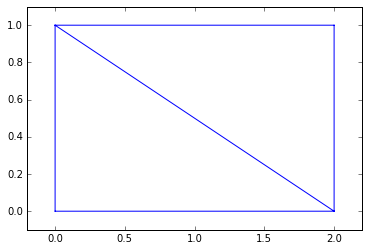

In [4]:
plot(mesh)

### Element matrix
The "element stiffness matrix", $K$ depends on the conductivity tensor $D$ and the triangle geometry.

$$ K_e = \int_{\Omega_e} B_e^T D B_e d\Omega $$


In [5]:
def Kmat(D, p, geometry):
    ''' Calculate K from the D matrix and the points '''
    # D contains the conductivity tensor
    # p contains the indices of the three points
    # making up the triangle
    assert(len(p) == 3)
    x0, y0 = geometry[p[0]]
    x1, y1 = geometry[p[1]]
    x2, y2 = geometry[p[2]]

    # Element area Ae
    Ae = 0.5*abs((x0 - x1)*(y2 - y1) - (y0 - y1)*(x2 - x1))

    # 'B' Matrix - representing the 'gradient' operator
    B = array([[y1 - y2, y2 - y0, y0 - y1],
               [x2 - x1, x0 - x2, x1 - x0]])/(2*Ae)

    K = Ae*matmul(B.transpose(), matmul(D, B))
    return K

### Matrix assembly (LHS)
The process of combining the local element matrices into a larger global matrix is called "assembly". It is really just a case of relabelling the indices with their global values, and adding the local matrices together.

In [6]:
def assemble_matrix(mesh, Dmat):
    geom, topo = mesh
    np = len(geom)
    Kglobal = zeros((np, np))
    
    for tri in topo:
        K = Kmat(Dmat, tri, geom)
        for i, idx in enumerate(tri):
            for j, jdx in enumerate(tri):
                Kglobal[idx, jdx] += K[i, j]
    return Kglobal

In [7]:
Dmat = array([[5.0, 0.0],
              [0.0, 5.0]])

In [8]:
Kglobal = assemble_matrix(mesh, Dmat)

The fully assembled left-hand side (LHS) looks like this:

In [9]:
print(Kglobal)

[[ 6.25 -1.25 -5.    0.  ]
 [-1.25  6.25  0.   -5.  ]
 [-5.    0.    6.25 -1.25]
 [ 0.   -5.   -1.25  6.25]]


### Vector assembly (RHS)
Now we need to perform RHS assembly on the vector $f$. This is similar to the matrix assembly above.

The individual vector for each element is defined in `fvec()` and they are combined together in `assemble_vector()`.

In [10]:
def fvec(s, p, geom):
    assert(len(p) == 3)
    x0, y0 = geometry[p[0]]
    x1, y1 = geometry[p[1]]
    x2, y2 = geometry[p[2]]

    # Element area Ae
    Ae = 0.5*abs((x0 - x1)*(y2 - y1) - (y0 - y1)*(x2 - x1))
    return s*Ae/3.0*ones(3)

def assemble_vector(mesh, s):
    geom, topo = mesh
    fg = zeros(len(geom))
    for tri in topo:
        f = fvec(s, tri, geom)
        for i, idx in enumerate(tri):
            fg[idx] += f[i]
    return fg

fglobal = assemble_vector(mesh, 3.0)

### Boundary flux terms
There are also some boundary flux terms in the example. Here we will add them directly to $f$.

In [11]:
fglobal += array([0.0, -10.0, 0.0, -10.0])

### Boundary conditions 

Dirichlet boundary conditions can be enforced by zeroing a row of the $K$ matrix, setting the diagonal entry to 1, and putting the desired value in the RHS $f$ vector

In [12]:
def set_bc(K, f, row, val):
    # Set BC
    K[row] = 0.0
    K[row, row] = 1.0
    f[row] = val

set_bc(Kglobal, fglobal, 0, 0.0)   
set_bc(Kglobal, fglobal, 2, 0.0)

Finally, we can refer the $K.u = f$ problem to a linear algebra solver which will use an LU method to get the answer

In [13]:
u = linalg.solve(Kglobal, fglobal)
print(u)


[-0.   -6.76  0.   -6.84]
